In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import osborne
import sinkhorn
from timer import timeit
import matrix_utils as mtu
import pandas as pd
import sys
sns.set_theme(style='white')

## Experiment 1 : Eigenvalue computation

In [22]:
scale = 1
M = scale * np.array([
    [3, 2, 1],
    [18, 2, 1],
    [2, 1, 2]
], dtype=float)

In [23]:
# compute eigenvalues & eigenvectors without balancing
# extremely low tolerance
eigval_unb, eigvec_unb = mtu.qr_algorithm(M, tol=1e-30)  # nothing is printed : converged
eigval_unb

array([ 900000.        , -344948.97427832,  144948.97427832])

In [24]:
# balance M
balance = osborne.osborne(np.log(mtu.zerodiag(M)), epsilon=1e-10, method='cycle', log_domain=True)

/tmp/ipykernel_76435/1055503622.py:2: RuntimeWarning: divide by zero encountered in log
  balance = osborne.osborne(np.log(mtu.zerodiag(M)), epsilon=1e-10, method='cycle', log_domain=True)


In [25]:
# compute eigenvalues after balance
balanced_M = np.diag(np.exp(balance)) @ M @ np.diag(np.exp(-balance))
eigval_bal, eigvec_bal = mtu.qr_algorithm(balanced_M, tol=1e-30)
eigval_bal

array([ 900000.        , -344948.97427832,  144948.97427832])

In [26]:
# evaluate errors on the integer eigenvalue 9
expected_err = np.linalg.norm(M, 'fro') * sys.float_info.epsilon
print(
    f'Errors w.r.t. integer eigenvalue (real = 9, machine precision * ||M||_F = {expected_err}):\n'
    f'Unbalanced : {"{:.6e}".format(abs(eigval_unb[0] - 9 * scale))}\n'
    f'Balanced : {"{:.6e}".format(abs(eigval_bal[0] - 9 * scale))}\n'
)

Errors w.r.t. integer eigenvalue (real = 9, machine precision * ||M||_F = 4.1659260572965357e-10):
Unbalanced : 3.492460e-10
Balanced : 1.164153e-10



In [31]:
mtu.conditioning_number(balanced_M)

35.94840920820976

## Experiment 2.1 : Osborne variants benchmark

In [ ]:
###########################################################
# WARNING : EXTREMELY LONG TO RUN #########################
###########################################################
DO_TEST = False

if DO_TEST:

    n_vals = np.array([30, 80, 150, 300, 400])
    m_vals = np.zeros(shape=(len(n_vals), 3), dtype=int)
    kappa_vals = np.zeros_like(m_vals)
    scale_vals = [1., 10., 50., 150., 1000.,]
    for i, _n in enumerate(n_vals):
        m_vals[i][0] = (_n * _n)//2 + 1
        m_vals[i][1] = 3 * (_n * _n)//4
        m_vals[i][2] = _n * (_n - 1) - 1

        kappa_vals[i][0] = m_vals[i][0] * (1. + 1000. * np.sqrt(_n) * np.random.rand())
        kappa_vals[i][1] = m_vals[i][1] * (1. + 1. * np.sqrt(_n) * np.random.rand())
        kappa_vals[i][2] = m_vals[i][2] * (1. + 10. * np.sqrt(_n) * np.random.rand())

    HYPERPARAMS = {  # lists with a wide range of param values. m, kappa and d are missing for now.
        'n': n_vals,
        'm': m_vals,
        'kappa': kappa_vals,
        'epsilon': [1e-3, 1e-5, 1e-8, 1e-12],
        'scale': scale_vals,
    }

    FUNCTIONS_TO_TIME = {
        'cyclic_osborne': osborne.cyclic_osborne,
        'greedy_osborne': osborne.greedy_osborne,
        'random_cyclic_osborne': osborne.random_cyclic_osborne,
        'random_osborne': osborne.random_osborne,
    }

In [ ]:
def time_osborne_log(mat: np.ndarray,
                     eps: float,
                     funcs_dict: dict) -> dict:
    results_dict = dict.fromkeys(list(funcs_dict.keys()), None)
    for func_name, func in funcs_dict.items():
        timeit(func, log_dict=results_dict)(mat, eps, history=False, log_domain=True)

    return results_dict

In [ ]:
def time_batch_params(
        params: dict,
        funcs: dict,
):
    rows = []
    printed = False
    for i_n, n in enumerate(params['n']):
        for m in params['m'][i_n]:
            for kappa in params['kappa'][i_n]:
                for scale in params['scale']:
                    mat = mtu.generate_matrix_from_cond(n, m, kappa, scale)
                    d = mtu.compute_diameter(mat)
                    log_mat = np.log(mat)
                    for epsilon in params['epsilon']:
                        row_params = {
                            'n': n,
                            'm': m,
                            'kappa': kappa,
                            'epsilon': epsilon,
                            'd': d,
                        }
                        row_times = time_osborne_log(log_mat, epsilon, funcs)
                        rows.append({**row_params, **row_times})
                        if not printed:
                            print(rows)
                            printed = True
            print(f'm = {m} done')
        print(f'n = {n} done')

    return rows

In [ ]:
if DO_TEST:
    rows = time_batch_params(HYPERPARAMS, FUNCTIONS_TO_TIME)
    osborne_results = pd.DataFrame(rows)

In [2]:
# load local file
osborne_results = pd.read_csv('/home/alderson/Desktop/MVA/Optimal_Transport/osborne_results.csv')

In [3]:
osborne_results

,Unnamed: 0,n,m,kappa,epsilon,d,cyclic_osborne,greedy_osborne,random_cyclic_osborne,random_osborne
0,0,30,451,2284442,1.000000e-03,0.628588,0.016302,0.020333,0.010161,0.029227
1,1,30,451,2284442,1.000000e-05,0.628588,0.016060,0.016351,0.016321,0.043220
2,2,30,451,2284442,1.000000e-08,0.628588,0.025930,0.027379,0.034738,0.101753
3,3,30,451,2284442,1.000000e-12,0.628588,0.053813,0.054332,0.046201,0.170029
4,4,30,451,2284442,1.000000e-03,10.729331,0.028581,0.017888,0.018090,0.043001
...,...,...,...,...,...,...,...,...,...,...
895,895,400,159599,14987921,1.000000e-12,11.035608,10.652327,13.982620,7.052285,29.208977
896,896,400,159599,14987921,1.000000e-03,75.248206,1.049308,1.807592,1.076563,4.204945
897,897,400,159599,14987921,1.000000e-05,75.248206,3.243779,3.774070,2.405229,9.947834
898,898,400,159599,14987921,1.000000e-08,75.248206,6.869572,7.877102,4.550850,18.112438


In [4]:
osborne_results['min(d, 1/epsilon)'] = np.minimum(osborne_results['d'], 1. / osborne_results['epsilon'])

osborne_results['cyclic_bound'] = (
    osborne_results['n']**2 *
    osborne_results['m'] *
    (1. / osborne_results['epsilon'])**2 *
    np.log(osborne_results['kappa'])
)
osborne_results['cyclic_cv_normalized'] = osborne_results['cyclic_osborne'] / osborne_results['cyclic_bound']

osborne_results['random_cyclic_bound'] = (
    osborne_results['n'] *
    osborne_results['m'] *
    (1. / osborne_results['epsilon']) *
    osborne_results['min(d, 1/epsilon)'] *
    np.log(osborne_results['kappa'])
)
osborne_results['random_cyclic_cv_normalized'] = osborne_results['random_cyclic_osborne'] / osborne_results['random_cyclic_bound']

osborne_results['greedy_bound'] = (
    osborne_results['n']**2 *
     (1. / osborne_results['epsilon']) *
    osborne_results['min(d, 1/epsilon)'] *
    np.log(osborne_results['kappa'])
)
osborne_results['greedy_cv_normalized'] = osborne_results['greedy_osborne'] / osborne_results['greedy_bound']

osborne_results['random_bound'] = (
    (1. / osborne_results['epsilon']) *
    osborne_results['min(d, 1/epsilon)'] *
    np.log(osborne_results['kappa'])
)
osborne_results['random_cv_normalized'] = osborne_results['random_osborne'] / osborne_results['random_bound']

In [5]:
osborne_results

,Unnamed: 0,n,m,kappa,epsilon,d,cyclic_osborne,greedy_osborne,random_cyclic_osborne,random_osborne,"min(d, 1/epsilon)",cyclic_bound,cyclic_cv_normalized,random_cyclic_bound,random_cyclic_cv_normalized,greedy_bound,greedy_cv_normalized,random_bound,random_cv_normalized
0,0,30,451,2284442,1.000000e-03,0.628588,0.016302,0.020333,0.010161,0.029227,0.628588,5.943039e+12,2.743069e-15,1.245241e+08,8.159953e-11,8.283201e+06,2.454718e-09,9.203556e+03,3.175584e-06
1,1,30,451,2284442,1.000000e-05,0.628588,0.016060,0.016351,0.016321,0.043220,0.628588,5.943039e+16,2.702248e-19,1.245241e+10,1.310690e-12,8.283201e+08,1.973995e-11,9.203556e+05,4.696060e-08
2,2,30,451,2284442,1.000000e-08,0.628588,0.025930,0.027379,0.034738,0.101753,0.628588,5.943039e+22,4.363145e-25,1.245241e+13,2.789667e-15,8.283201e+11,3.305385e-14,9.203556e+08,1.105585e-10
3,3,30,451,2284442,1.000000e-12,0.628588,0.053813,0.054332,0.046201,0.170029,0.628588,5.943039e+30,9.054726e-33,1.245241e+17,3.710180e-19,8.283201e+15,6.559360e-18,9.203556e+12,1.847427e-14
4,4,30,451,2284442,1.000000e-03,10.729331,0.028581,0.017888,0.018090,0.043001,10.729331,5.943039e+12,4.809170e-15,2.125494e+09,8.510819e-12,1.413854e+08,1.265202e-10,1.570949e+05,2.737276e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,895,400,159599,14987921,1.000000e-12,11.035608,10.652327,13.982620,7.052285,29.208977,11.035608,4.219224e+35,2.524712e-35,1.164043e+22,6.058442e-22,2.917418e+19,4.792806e-19,1.823386e+14,1.601908e-13
896,896,400,159599,14987921,1.000000e-03,75.248206,1.049308,1.807592,1.076563,4.204945,75.248206,4.219224e+17,2.486970e-18,7.937227e+13,1.356347e-14,1.989292e+11,9.086610e-12,1.243308e+06,3.382063e-06
897,897,400,159599,14987921,1.000000e-05,75.248206,3.243779,3.774070,2.405229,9.947834,75.248206,4.219224e+21,7.688092e-22,7.937227e+15,3.030314e-16,1.989292e+13,1.897192e-13,1.243308e+08,8.001104e-08
898,898,400,159599,14987921,1.000000e-08,75.248206,6.869572,7.877102,4.550850,18.112438,75.248206,4.219224e+27,1.628160e-27,7.937227e+18,5.733552e-19,1.989292e+16,3.959751e-16,1.243308e+11,1.456794e-10


In [6]:
np.max([np.max(osborne_results['cyclic_osborne']), np.max(osborne_results['random_cyclic_osborne']), np.max(osborne_results['greedy_osborne']), np.max(osborne_results['random_osborne'])])

50.54419446899556

In [7]:
osborne_results['n_square'] = osborne_results['n']**2

Text(0, 0.5, 'log(execution time)')

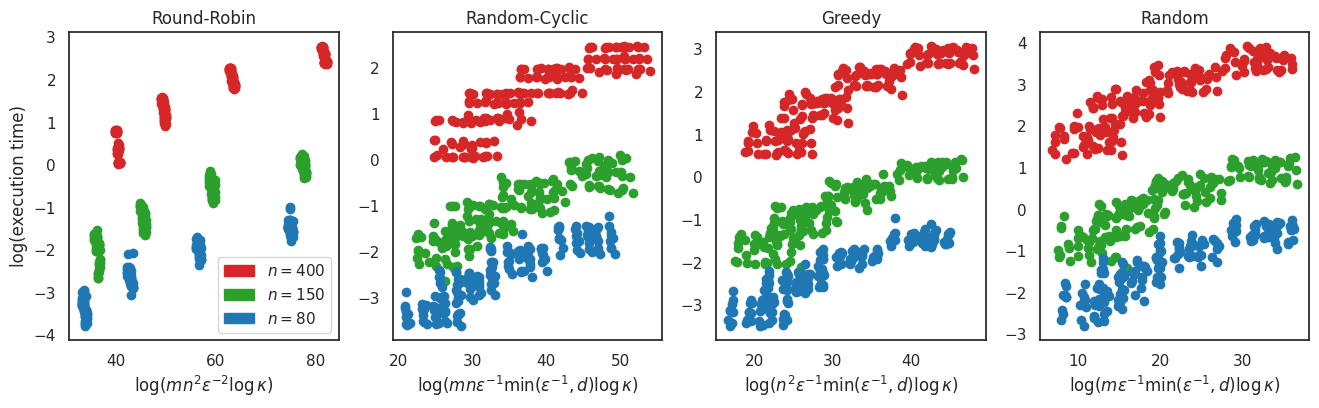

In [8]:
_, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].scatter(np.log(osborne_results.loc[osborne_results['n'] == 400]['cyclic_bound']), np.log(osborne_results.loc[osborne_results['n'] == 400]['cyclic_osborne']), color='tab:red')
red_patch = mpatches.Patch(color='tab:red', label='$n = 400$')
green_patch = mpatches.Patch(color='tab:green', label='$n = 150$')
blue_patch = mpatches.Patch(color='tab:blue', label='$n = 80$')
ax[0].legend(handles=[red_patch, green_patch, blue_patch])
ax[0].set_title('Round-Robin')
ax[0].set_xlabel(r'$\log(mn^2 \varepsilon^{-2} \log \kappa)$')

ax[1].scatter(np.log(osborne_results.loc[osborne_results['n'] == 400]['random_cyclic_bound']), np.log(osborne_results.loc[osborne_results['n'] == 400]['random_cyclic_osborne']), color='tab:red')
ax[1].set_title('Random-Cyclic')
ax[1].set_xlabel(r'$\log(mn \varepsilon^{-1} \min(\varepsilon^{-1}, d) \log \kappa)$')
ax[2].scatter(np.log(osborne_results.loc[osborne_results['n'] == 400]['greedy_bound']), np.log(osborne_results.loc[osborne_results['n'] == 400]['greedy_osborne']), color='tab:red')
ax[2].set_title('Greedy')
ax[2].set_xlabel(r'$\log(n^2 \varepsilon^{-1} \min(\varepsilon^{-1}, d) \log \kappa)$')
ax[3].scatter(np.log(osborne_results.loc[osborne_results['n'] == 400]['random_bound']), np.log(osborne_results.loc[osborne_results['n'] == 400]['random_osborne']), color='tab:red')
ax[3].set_title('Random')
ax[3].set_xlabel(r'$\log(m \varepsilon^{-1} \min(\varepsilon^{-1}, d) \log \kappa)$')


ax[0].scatter(np.log(osborne_results.loc[osborne_results['n'] == 150]['cyclic_bound']), np.log(osborne_results.loc[osborne_results['n'] == 150]['cyclic_osborne']), color='tab:green')
ax[1].scatter(np.log(osborne_results.loc[osborne_results['n'] == 150]['random_cyclic_bound']), np.log(osborne_results.loc[osborne_results['n'] == 150]['random_cyclic_osborne']), color='tab:green')
ax[2].scatter(np.log(osborne_results.loc[osborne_results['n'] == 150]['greedy_bound']), np.log(osborne_results.loc[osborne_results['n'] == 150]['greedy_osborne']), color='tab:green')
ax[3].scatter(np.log(osborne_results.loc[osborne_results['n'] == 150]['random_bound']), np.log(osborne_results.loc[osborne_results['n'] == 150]['random_osborne']), color='tab:green')

ax[0].scatter(np.log(osborne_results.loc[osborne_results['n'] == 80]['cyclic_bound']), np.log(osborne_results.loc[osborne_results['n'] == 80]['cyclic_osborne']), color='tab:blue')
ax[1].scatter(np.log(osborne_results.loc[osborne_results['n'] == 80]['random_cyclic_bound']), np.log(osborne_results.loc[osborne_results['n'] == 80]['random_cyclic_osborne']), color='tab:blue')
ax[2].scatter(np.log(osborne_results.loc[osborne_results['n'] == 80]['greedy_bound']), np.log(osborne_results.loc[osborne_results['n'] == 80]['greedy_osborne']), color='tab:blue')
ax[3].scatter(np.log(osborne_results.loc[osborne_results['n'] == 80]['random_bound']), np.log(osborne_results.loc[osborne_results['n'] == 80]['random_osborne']), color='tab:blue')

ax[0].set_ylabel('log(execution time)')

In [9]:
mean_random_vs_cyclic = np.mean(osborne_results['random_osborne'] / osborne_results['cyclic_osborne'])
std_random_vs_cyclic = np.std(osborne_results['random_osborne'] / osborne_results['cyclic_osborne'])
print(f'Random Osborne is longer to execute than Round-Robin cyclic Osborne by a multiplicative factor in '
      f'[{"{:.2f}".format(mean_random_vs_cyclic)} - 2*{"{:.2f}".format(std_random_vs_cyclic)} '
      f'= {"{:.2f}".format(mean_random_vs_cyclic - 2 * std_random_vs_cyclic)},'
      f' {"{:.2f}".format(mean_random_vs_cyclic)} + 2*{"{:.2f}".format(std_random_vs_cyclic)}'
      f' = {"{:.2f}".format(mean_random_vs_cyclic + 2 * std_random_vs_cyclic)}] (95% CI)')

Random Osborne is longer to execute than Round-Robin cyclic Osborne by a multiplicative factor in [3.04 - 2*0.62 = 1.80, 3.04 + 2*0.62 = 4.27] (95% CI)


In [10]:
# Compute 95% CIs for all variants
mean_rc_vs_cyclic = np.mean(osborne_results['random_cyclic_osborne'] / osborne_results['cyclic_osborne'])
std_rc_vs_cyclic = np.std(osborne_results['random_cyclic_osborne'] / osborne_results['cyclic_osborne'])
mean_greedy_vs_cyclic = np.mean(osborne_results['greedy_osborne'] / osborne_results['cyclic_osborne'])
std_greedy_vs_cyclic = np.std(osborne_results['greedy_osborne'] / osborne_results['cyclic_osborne'])

print(f'Random-Cyclic vs Round-Robin Cyclic : '
      f'[{"{:.2f}".format(mean_rc_vs_cyclic - 2 * std_rc_vs_cyclic)}, '
      f'{"{:.2f}".format(mean_rc_vs_cyclic + 2 * std_rc_vs_cyclic)}], \n'
      f'Greedy vs Round-Robin Cyclic : '
      f'[{"{:.2f}".format(mean_greedy_vs_cyclic - 2 * std_greedy_vs_cyclic)}, '
      f'{"{:.2f}".format(mean_greedy_vs_cyclic + 2 * std_greedy_vs_cyclic)}]')

Random-Cyclic vs Round-Robin Cyclic : [0.54, 1.27], 
Greedy vs Round-Robin Cyclic : [0.83, 1.71]


## Experiment 2.2 : convergence plots

In [19]:
test_matrix = mtu.generate_matrix_from_cond(n=50, m=1500, target_cond=1e15, scale=100.)
_, rr_hist = osborne.cyclic_osborne(np.log(test_matrix), epsilon=1e-12, history=True, log_domain=True)
_, rc_hist = osborne.random_cyclic_osborne(np.log(test_matrix), epsilon=1e-12, history=True, log_domain=True)
_, gr_hist = osborne.greedy_osborne(np.log(test_matrix), epsilon=1e-12, history=True, log_domain=True)
_, rd_hist = osborne.random_osborne(np.log(test_matrix), epsilon=1e-12, history=True, log_domain=True)

/tmp/ipykernel_61834/2455116490.py:2: RuntimeWarning: divide by zero encountered in log
  _, rr_hist = osborne.cyclic_osborne(np.log(test_matrix), epsilon=1e-12, history=True, log_domain=True)
/tmp/ipykernel_61834/2455116490.py:3: RuntimeWarning: divide by zero encountered in log
  _, rc_hist = osborne.random_cyclic_osborne(np.log(test_matrix), epsilon=1e-12, history=True, log_domain=True)
/tmp/ipykernel_61834/2455116490.py:4: RuntimeWarning: divide by zero encountered in log
  _, gr_hist = osborne.greedy_osborne(np.log(test_matrix), epsilon=1e-12, history=True, log_domain=True)
/tmp/ipykernel_61834/2455116490.py:5: RuntimeWarning: divide by zero encountered in log
  _, rd_hist = osborne.random_osborne(np.log(test_matrix), epsilon=1e-12, history=True, log_domain=True)


In [20]:
rr_pot_hist = osborne.potential_from_increment_history(rr_hist, test_matrix)
rc_pot_hist = osborne.potential_from_increment_history(rc_hist, test_matrix)
gr_pot_hist = osborne.potential_from_increment_history(gr_hist, test_matrix)
rd_pot_hist = osborne.potential_from_increment_history(rd_hist, test_matrix)

Text(0.5, 1.0, 'Random')

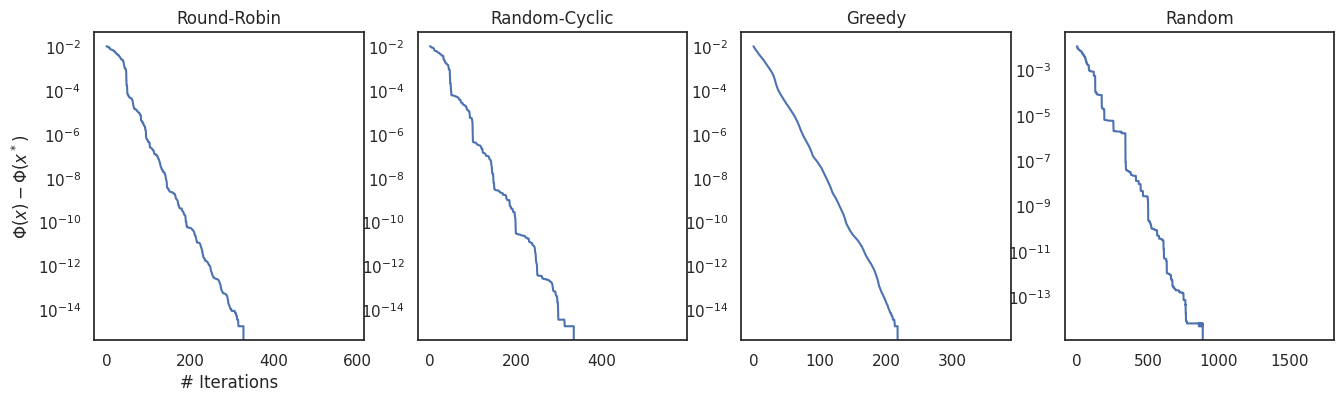

In [21]:
_, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].semilogy(rr_pot_hist - rr_pot_hist[-1])
ax[0].set_title('Round-Robin')
ax[0].set_xlabel('# Iterations')
ax[0].set_ylabel(r'$\Phi(x) - \Phi(x^*)$')
ax[1].semilogy(rc_pot_hist - rc_pot_hist[-1])
ax[1].set_title('Random-Cyclic')
ax[2].semilogy(gr_pot_hist - gr_pot_hist[-1])
ax[2].set_title('Greedy')
ax[3].semilogy(rd_pot_hist - rd_pot_hist[-1])
ax[3].set_title('Random')

## Experiment 3 : numerical stability

In [22]:
balance_unstabilized = osborne.cyclic_osborne(test_matrix, 1e-15, history=False, log_domain=False)

In [23]:
balance_stabilized = osborne.cyclic_osborne(np.log(test_matrix), 1e-15, history=False, log_domain=True)

/tmp/ipykernel_61834/2761216402.py:1: RuntimeWarning: divide by zero encountered in log
  balance_stabilized = osborne.cyclic_osborne(np.log(test_matrix), 1e-15, history=False, log_domain=True)


In [24]:
np.linalg.norm(balance_stabilized - balance_unstabilized, 1) / sys.float_info.epsilon

76.0

## Experiment 4 : Sinkhorn

### Experiment 4.1 : Sinkhorn variants convergence

In [90]:
#################################################
# OT experiments ################################
#################################################
# These take about an hour to run

DO_TEST_SINKHORN = True

if DO_TEST_SINKHORN:
    mu_1, mu_2 = 0.25, 0.8
    n_vals = [50, 200, 800]
    reg_vals = [1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4]
    sigma_vals = [0.06, 0.2]

    HYPERPARAMS_SINKHORN = {
        'n': n_vals,
        'reg': reg_vals,
        'sigma': sigma_vals,
    }

In [91]:
def time_sinkhorn(cost_mat,
                  reg,
                  a,
                  b,
                  eps_prime):
    results_dict = {'sinkhorn_log': None,
                    'greenkhorn': None,
                    'sinkhorn_random': None}
    n = cost_mat.shape[0]
    _, _, _, log_issue = timeit(sinkhorn.sinkhorn_log, results_dict)(-cost_mat/reg, a, b, 10000000000, 10 * n, eps_prime)
    _, _, _, greedy_issue = timeit(sinkhorn.greenkhorn, results_dict)(cost_mat, reg, a, b, 10000000000, 10 * n, eps_prime)

    if log_issue:
        results_dict['sinkhorn_log'] = np.nan
    if greedy_issue:
        results_dict['greenkhorn'] = np.nan

    return results_dict

In [92]:
def time_batch_sinkhorn(params):
    rows = []
    printed = False
    vmin = 0.02
    for _n in params['n']:
        t = np.arange(_n) / _n
        gauss = lambda t0, s: np.exp(-0.5 * ((t - t0) / s)**2)
        normalize = lambda p: p / np.sum(p)
        yy, xx = np.meshgrid(t, t)
        _C = (xx - yy)**2
        for _sigma in params['sigma']:
            a = gauss(mu_1, _sigma)

            b = gauss(mu_2, _sigma)

            a = normalize(a + np.max(a) * vmin)

            b = normalize(b + np.max(b) * vmin)
            for _reg in params['reg']:
                epsilon = _reg / (4 * np.log(_n))
                _L = np.max(_C)
                epsilon_prime = epsilon / (8 * _L)
                row_params = {
                    'n': _n,
                    'epsilon': epsilon,
                    'eta': _reg,
                    'epsilon_prime': epsilon_prime,
                    'L': _L,
                    'kappa': mtu.conditioning_number(np.exp(- _C / _reg))
                }

                row_times = time_sinkhorn(_C, _reg, a, b, epsilon_prime)
                rows.append({**row_params, **row_times})
                if not printed:
                    print(rows)
                    printed = True
                print(f'reg = {_reg} done')
        print(f'n = {_n} done')

    return rows

In [93]:
if DO_TEST_SINKHORN:
    rows_sinkhorn = time_batch_sinkhorn(HYPERPARAMS_SINKHORN)
    sinkhorn_df = pd.DataFrame(rows_sinkhorn)

[{'n': 50, 'epsilon': 0.006390555465883287, 'eta': 0.1, 'epsilon_prime': 0.0008317570108656924, 'L': 0.9603999999999999, 'kappa': 17068529.135888297, 'sinkhorn_log': 0.05799860198749229, 'greenkhorn': 0.006677874000160955, 'sinkhorn_random': None}]
reg = 0.1 done
reg = 0.05 done
reg = 0.01 done
reg = 0.005 done


/home/alderson/Mines/3A/MVA/Optimal_Transport/OT_Project/matrix_utils.py:67: RuntimeWarning: overflow encountered in scalar divide
  return np.sum(mat) / min_nonzero_coeff


reg = 0.001 done
reg = 0.0005 done
reg = 0.1 done
reg = 0.05 done
reg = 0.01 done
reg = 0.005 done
reg = 0.001 done
reg = 0.0005 done
n = 50 done
reg = 0.1 done
reg = 0.05 done
reg = 0.01 done
reg = 0.005 done
reg = 0.001 done
reg = 0.0005 done
reg = 0.1 done
reg = 0.05 done
reg = 0.01 done
reg = 0.005 done
reg = 0.001 done
reg = 0.0005 done
n = 200 done
reg = 0.1 done
reg = 0.05 done
reg = 0.01 done
reg = 0.005 done
reg = 0.001 done
reg = 0.0005 done
reg = 0.1 done
reg = 0.05 done
reg = 0.01 done
reg = 0.005 done
reg = 0.001 done
reg = 0.0005 done
n = 800 done


In [94]:
sinkhorn_df

,n,epsilon,eta,epsilon_prime,L,kappa,sinkhorn_log,greenkhorn,sinkhorn_random
0,50,0.006391,0.1000,0.000832,0.960400,1.706853e+07,0.057999,0.006678,None
1,50,0.003195,0.0500,0.000416,0.960400,1.903030e+11,0.047912,0.010432,None
2,50,0.000639,0.0100,0.000083,0.960400,2.143433e+44,0.039076,0.031383,None
3,50,0.000320,0.0050,0.000042,0.960400,7.903976e+85,0.039134,0.068351,None
4,50,0.000064,0.0010,0.000008,0.960400,inf,0.043037,0.382169,None
5,50,0.000032,0.0005,0.000004,0.960400,inf,0.164614,1.001722,None
6,50,0.006391,0.1000,0.000832,0.960400,1.706853e+07,0.037245,0.009926,None
7,50,0.003195,0.0500,0.000416,0.960400,1.903030e+11,0.036666,0.009922,None
8,50,0.000639,0.0100,0.000083,0.960400,2.143433e+44,0.040256,0.054313,None
9,50,0.000320,0.0050,0.000042,0.960400,7.903976e+85,0.040797,0.109915,None


In [127]:
sinkhorn_df['sinkhorn_bound'] = sinkhorn_df['n']**2 * np.log(sinkhorn_df['n']) * sinkhorn_df['L']**3 * (1 / sinkhorn_df['epsilon'])**3
sinkhorn_df['greenkhorn_bound'] = sinkhorn_df['n']**2 * (1 / sinkhorn_df['epsilon_prime']**2) * np.log(sinkhorn_df['kappa'])

Text(0.5, 1.0, 'Greenkhorn')

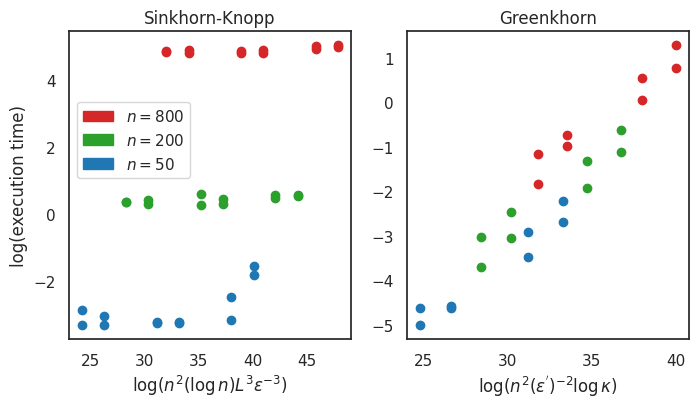

In [128]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(np.log(sinkhorn_df.loc[sinkhorn_df['n'] == 50]['sinkhorn_bound']), np.log(sinkhorn_df.loc[sinkhorn_df['n'] == 50]['sinkhorn_log']), color='tab:blue')
ax[0].scatter(np.log(sinkhorn_df.loc[sinkhorn_df['n'] == 200]['sinkhorn_bound']), np.log(sinkhorn_df.loc[sinkhorn_df['n'] == 200]['sinkhorn_log']), color='tab:green')
ax[0].scatter(np.log(sinkhorn_df.loc[sinkhorn_df['n'] == 800]['sinkhorn_bound']), np.log(sinkhorn_df.loc[sinkhorn_df['n'] == 800]['sinkhorn_log']), color='tab:red')
red_patch = mpatches.Patch(color='tab:red', label='$n = 800$')
green_patch = mpatches.Patch(color='tab:green', label='$n = 200$')
blue_patch = mpatches.Patch(color='tab:blue', label='$n = 50$')
ax[0].legend(handles=[red_patch, green_patch, blue_patch], bbox_to_anchor=(0., 0.5), loc='lower left')
ax[0].set_title('Sinkhorn-Knopp')
ax[0].set_xlabel(r'$\log(n^2 (\log n) L^3 \varepsilon^{-3})$')
ax[0].set_ylabel(r'log(execution time)')

ax[1].scatter(np.log(sinkhorn_df.loc[sinkhorn_df['n'] == 50]['greenkhorn_bound']), np.log(sinkhorn_df.loc[sinkhorn_df['n'] == 50]['greenkhorn']), color='tab:blue')
ax[1].scatter(np.log(sinkhorn_df.loc[sinkhorn_df['n'] == 200]['greenkhorn_bound']), np.log(sinkhorn_df.loc[sinkhorn_df['n'] == 200]['greenkhorn']), color='tab:green')
ax[1].scatter(np.log(sinkhorn_df.loc[sinkhorn_df['n'] == 800]['greenkhorn_bound']), np.log(sinkhorn_df.loc[sinkhorn_df['n'] == 800]['greenkhorn']), color='tab:red')
ax[1].set_xlabel(r"$\log(n^2 (\varepsilon^{'})^{-2} \log \kappa)$")
ax[1].set_title('Greenkhorn')

In [126]:
m_greenkhorn_vs_sinkhorn = np.mean(sinkhorn_df['greenkhorn'] / sinkhorn_df['sinkhorn_log'])
std_greenkhorn_vs_sinkhorn = np.std(sinkhorn_df['greenkhorn'] / sinkhorn_df['sinkhorn_log'])
print(f'Greenkhorn / Sinkhorn_log time\n'
      f'mean : {"{:.2f}".format(m_greenkhorn_vs_sinkhorn)}\n'
      f'std : {"{:.2f}".format(std_greenkhorn_vs_sinkhorn)}')

Greenkhorn / Sinkhorn_log time
mean : 1.37
std : 2.43


In [118]:
sinkhorn_df['greenkhorn/sinkhorn_log'] = sinkhorn_df['greenkhorn'] / sinkhorn_df['sinkhorn_log']
sinkhorn_df_n_mean = sinkhorn_df.groupby('n')['greenkhorn/sinkhorn_log'].mean()
sinkhorn_df_n_std = sinkhorn_df.groupby('n')['greenkhorn/sinkhorn_log'].std()

In [120]:
print(f'Greenkhorn / Sinkhorn_log time, groupby n :\n'
      f'n = 50 : mean = {"{:.2f}".format(sinkhorn_df_n_mean[50])}, std = {"{:.2f}".format(sinkhorn_df_n_std[50])}\n'
      f'n = 200 : mean = {"{:.2f}".format(sinkhorn_df_n_mean[200])}, std = {"{:.2f}".format(sinkhorn_df_n_std[200])}\n'
      f'n = 800 : mean = {"{:.2f}".format(sinkhorn_df_n_mean[800])}, std = {"{:.2f}".format(sinkhorn_df_n_std[800])}\n'
      )

Greenkhorn / Sinkhorn_log time, groupby n :
n = 50 : mean = 3.18, std = 3.46
n = 200 : mean = 0.87, std = 1.27
n = 800 : mean = 0.07, std = 0.10



Text(-90, -20, '$\\mu = 0.07, \\sigma = 0.10$')

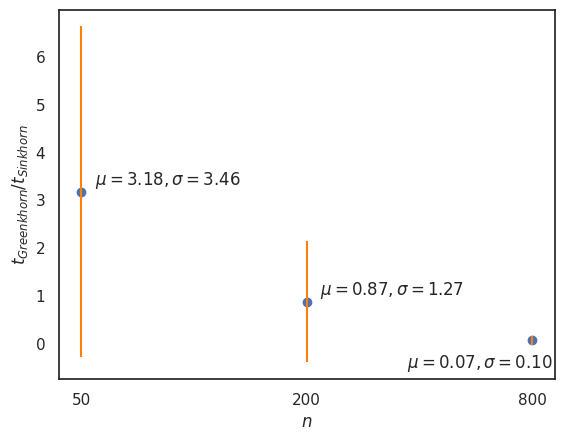

In [154]:
plt.errorbar(range(3), y=sinkhorn_df_n_mean.values, yerr=sinkhorn_df_n_std.values,fmt='None', color='tab:orange')
plt.scatter(range(3), sinkhorn_df_n_mean.values)
plt.xticks(range(3), labels=['50', '200', '800'])
plt.xlabel('$n$')
plt.ylabel(r'$t_{Greenkhorn} / t_{Sinkhorn}$')
for i in range(2):
    plt.annotate(f'$\mu = {"{:.2f}".format(sinkhorn_df_n_mean.values[i])}, \sigma = {"{:.2f}".format(sinkhorn_df_n_std.values[i])}$', xy=(i, sinkhorn_df_n_mean.values[i]), xytext=(10, 5), textcoords='offset points')

plt.annotate(f'$\mu = {"{:.2f}".format(sinkhorn_df_n_mean.values[2])}, \sigma = {"{:.2f}".format(sinkhorn_df_n_std.values[2])}$', xy=(2, sinkhorn_df_n_mean.values[2]), xytext=(-90, -20), textcoords='offset points')

In [121]:
sinkhorn_df.to_csv('/home/alderson/Desktop/MVA/Optimal_Transport/sinkhorn_results.csv')

## Experiment 5 : Stochastic Optimal Transport through semi-dual

In [65]:
import ot

In [155]:
_n = 200
vmin = 0.02
_sigma = 0.06
mu_1 = 0.25
mu_2 = 0.80
t = np.arange(_n) / _n
gauss = lambda t0, s: np.exp(-0.5 * ((t - t0) / s)**2)
normalize = lambda p: p / np.sum(p)
yy, xx = np.meshgrid(t, t)
_C = (xx - yy)**2
a = gauss(mu_1, _sigma)
b = gauss(mu_2, _sigma)
a = normalize(a + np.max(a) * vmin)
b = normalize(b + np.max(b) * vmin)

_reg = 5e-4

In [156]:
u, v, _, _ = sinkhorn.sinkhorn_log(-_C / _reg, a, b, max_iter=10000)

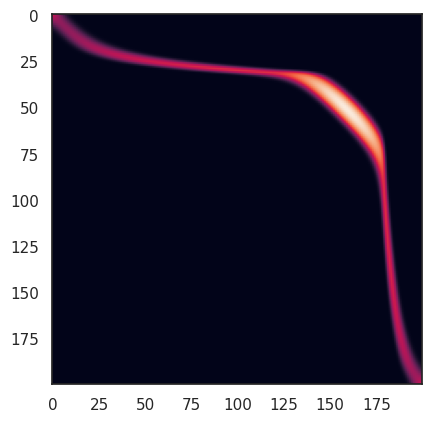

In [157]:
plt.imshow(np.log(np.diag(u) @ np.exp(-_C / _reg) @ np.diag(v) + 1e-5))

In [158]:
transp_sag = ot.stochastic.solve_semi_dual_entropic(a, b, _C, 5e-4, method='sag')

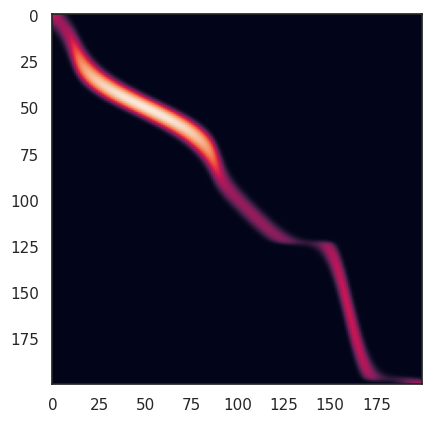

In [159]:
plt.imshow(np.log(transp_sag + 1e-5))

Text(0.5, 1.0, 'Transport matrix (POT SAG Semi-Dual)')

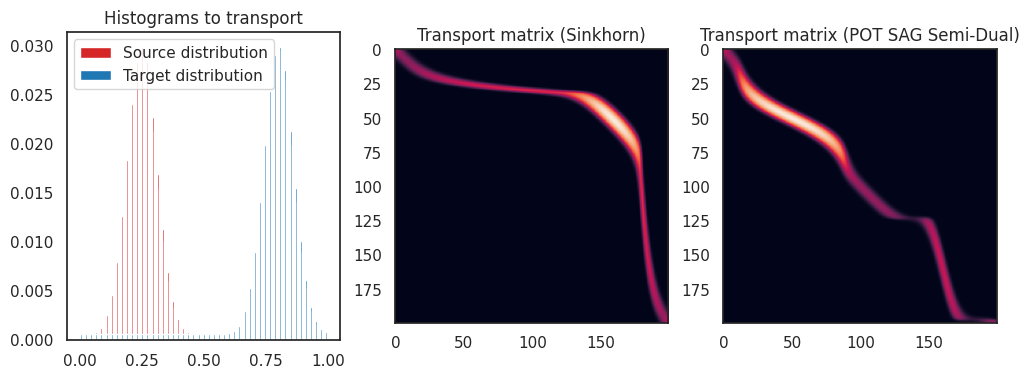

In [161]:
_, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].bar(t, a, width=1/len(t), label='Source distribution', color='tab:red')
ax[0].bar(t, b, width=1/len(t), label='Target distribution', color='tab:blue')
ax[0].set_title('Histograms to transport')
ax[0].legend()

ax[1].imshow(np.log(np.diag(u) @ np.exp(-_C / _reg) @ np.diag(v) + 1e-5))
ax[1].set_title('Transport matrix (Sinkhorn)')

ax[2].imshow(np.log(transp_sag + 1e-5))
ax[2].set_title('Transport matrix (POT SAG Semi-Dual)')